In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import Estimate
import figure 
from EconModel import cpptools
import pickle

from LimitedCommitmentModel import LimitedCommitmentModelClass

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)


plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

SAVE = False

# c++ settings

do_compile = True
threads = 20
T = 20
#cpptools.setup_nlopt(folder='cppfuncs/', do_print = True) #install nlopt

# Load the model

In [2]:
name = 'model_NC'
model_name = "model_NC"

specs = {}
#specs.update({f'test2':{'latexname':'limited', 'par':{ 'T':T, 'num_K': 5, 'num_A': 10 ,  'do_HK': False, 'threads':threads,'bargaining':0}}})

specs.update({f'model_NC':{'latexname':'limited', 'par':{ 'T':T, 'do_HK': False, 'threads':threads,'bargaining':2}}})
#specs.update({f'model_FC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': False, 'threads':threads,'bargaining':0}}})

# solve different models
models = {}
for m,(name,spec) in enumerate(specs.items()):
    
    # setup model
    model = LimitedCommitmentModelClass(name=name,par=spec['par'])
    model.spec = spec

    compile_now = True if do_compile & (m==0) else False
    model.link_to_cpp(force_compile=compile_now)
    

# setup model
#model = LimitedCommitmentModelClass(name=name)    
#model.link_to_cpp(force_compile=True)


#load par and sol
pickle_file = f'output/{name}_sol.pickle'

with open(pickle_file, 'rb') as f:
    model.sol = pickle.load(f)

pickle_file = f'output/{name}_par.pickle'

with open(pickle_file, 'rb') as f:
    model.par = pickle.load(f)




In [3]:
#TEST 
model.sim.labor_w
print("i1")
par = model.par
sim = model.sim 
print("i2")
#update stockastic elements.
shape_sim = (par.simN,par.T)
print("i3")
sim.draw_love = par.sigma_love * np.random.normal(size=shape_sim)
sim.draw_Kw = par.sigma_K * np.random.normal(size=shape_sim)
sim.draw_Km = par.sigma_K * np.random.normal(size=shape_sim)
print("i4")
#simulate the data
model.simulate()
print("i5")
#Save the data in a data frame
data_nu = {}
data   = pd.DataFrame()



i1
i2
i3
i4
i5


c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:206: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['delta_omega_w'] = data['omega_w']-data['omega_w_l']
c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:207: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['delta_omega_m'] = data['omega_m']-data['omega_m_l']
c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:208: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

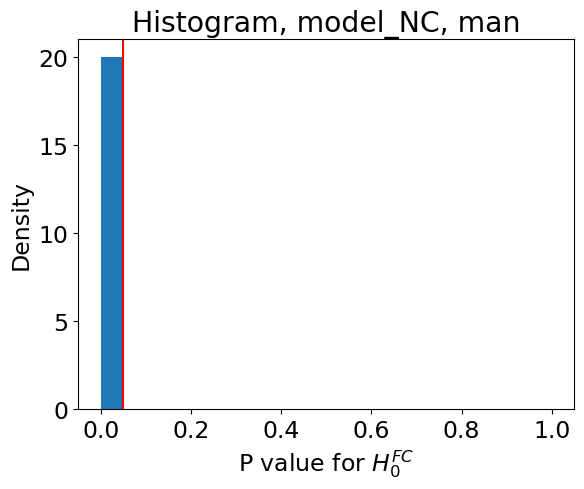

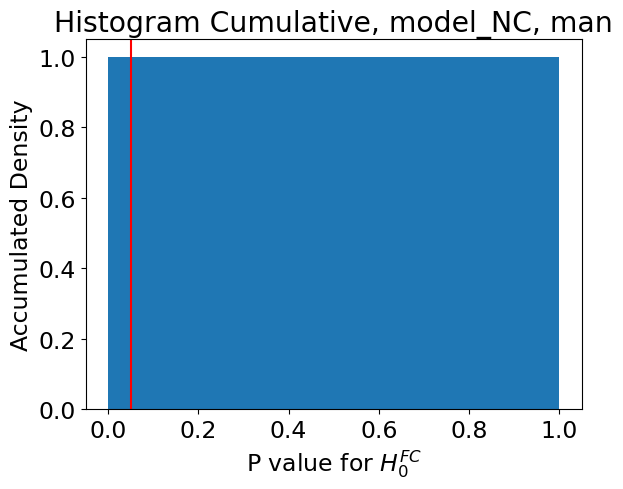

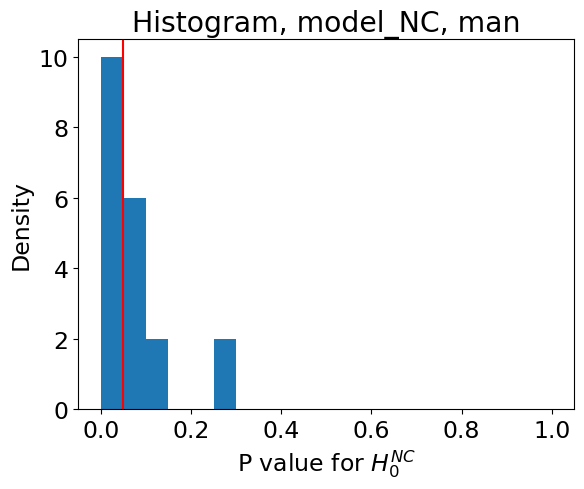

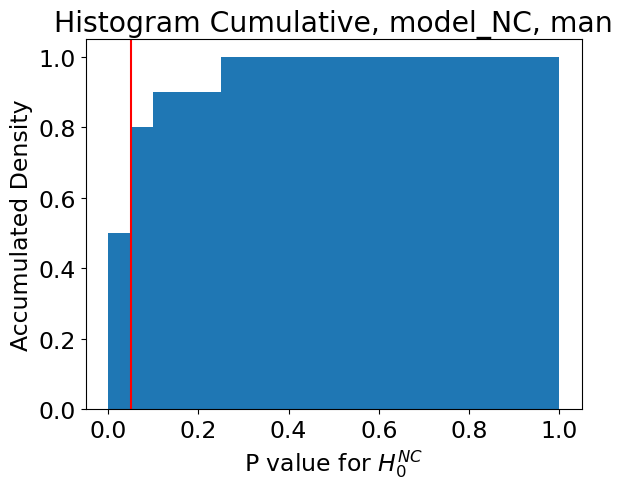

In [4]:
# Ændrer N
# ændrer S
# ændrer estimaat kontrol 


model.sim.init_love[:] = 0.2
model.sim.init_A[:] = 2.0

np.random.seed(model.par.seed)

no_sim = 10

wald_FC_w_pval = np.nan + np.ones(no_sim) 
wald_NC_w_pval = np.nan + np.ones(no_sim)
wald_FC_m_pval = np.nan + np.ones(no_sim)
wald_NC_m_pval = np.nan + np.ones(no_sim)


wald_FC_w_fval = np.nan + np.ones(no_sim) 
wald_NC_w_fval = np.nan + np.ones(no_sim)
wald_FC_m_fval = np.nan + np.ones(no_sim)
wald_NC_m_fval = np.nan + np.ones(no_sim)

N_w= np.nan + np.ones(no_sim) 
N_m= np.nan + np.ones(no_sim) 

for i in range(no_sim):
    data = Estimate.create_data(model,start_p = 1, end_p = model.par.T-1)
    data = Estimate.create_variable(data, model.par)

    #_, wald_FC_w , wald_NC_w, N_w[i] = Estimate.main_est(data,gender= "w", do_estimate_omega = False, print_reg = False, shadow_value_simple=False)
    _, wald_FC_m , wald_NC_m, N_m[i]= Estimate.main_est(data,gender= "m", do_estimate_omega = False, print_reg = False, shadow_value_simple=False)

    #wald_FC_w_pval[i] = wald_FC_w.pvalue
    wald_FC_m_pval[i] = wald_FC_m.pvalue
    #wald_NC_w_pval[i] = wald_NC_w.pvalue
    wald_NC_m_pval[i] = wald_NC_m.pvalue
    
    #wald_FC_w_fval[i] = wald_FC_w.fvalue
    wald_FC_m_fval[i] = wald_FC_m.fvalue
    #wald_NC_w_fval[i] = wald_NC_w.fvalue
    wald_NC_m_fval[i] = wald_NC_m.fvalue


figure.plot_hist("man", "FC", model_name,  wald_FC_m_pval, model)
#figure.plot_hist("woman", "FC", model_name,  wald_FC_w_pval, model)
figure.plot_hist("man", "NC", model_name, wald_NC_m_pval, model)
#figure.plot_hist("woman", "NC", model_name,  wald_NC_w_pval, model)

#TODO PRØV AT ÆNDRE N FOR AT SE HVORDAN RESULTATERNE PÅVIRKES AF DET
# lav to af dissse en til test model og en til test estiamte

In [5]:
data2 = data
do_estimate_omega = False
print_reg = False
shadow_value_simple = True
    #gender = w, woman, 
gender = "m"
if gender == "w":
    spouse = "m"
else:
    spouse = "w"
    gender = "m"

#FOR WOMAN
if do_estimate_omega:
    data2['wage_shock']=data2[f'omega_res_{gender}']
    data2['wage_shock_l']=data2[f'omega_res_{gender}_l']
    data2['wage_shock_l2']=data2[f'omega_res_{gender}_l2']
    data2['wage_shock_j']=data2[f'omega_res_{spouse}_m']
    data2['wage_shock_j_l']=data2[f'omega_res_{spouse}_l']
    data2['wage_shock_j_l2']=data2[f'omega_res_{spouse}_l2']
else:
    data2['wage_shock']=data2[f'delta_omega_{gender}']
    data2['wage_shock_l']=data2[f'delta_omega_{gender}_l']
    data2['wage_shock_l2']=data2[f'delta_omega_{gender}_l2']
    data2['wage_shock_j']=data2[f'delta_omega_{spouse}']
    data2['wage_shock_j_l']=data2[f'delta_omega_{spouse}_l']
    data2['wage_shock_j_l2']=data2[f'delta_omega_{spouse}_l2']

data2['BMI'] = data2[f'delta_log_BMI_{gender}']
data2['BMI_l'] = data2[f'delta_log_BMI_{gender}_l']
data2['BMI_l2'] = data2[f'delta_log_BMI_{gender}_l2']
data2['BMI_j'] = data2[f'delta_log_BMI_{spouse}']
data2['BMI_j_l'] = data2[f'delta_log_BMI_{spouse}_l']
data2['BMI_j_l2'] = data2[f'delta_log_BMI_{spouse}_l2']

    
    
    
data_regress = data2[['t','init_barg','log_earnings_w', 'log_earnings_m','log_earnings_w_l', 'log_earnings_m_l', 'inc_share_w', 'inc_share_w_l','log_wealth', 'wealth_F',  f'y_{gender}', 'idx', 'wage_shock','wage_shock_l','wage_shock_l2','wage_shock_j','wage_shock_j_l','wage_shock_j_l2','BMI','BMI_l','BMI_l2','BMI_j','BMI_j_l','BMI_j_l2',f'control_part_inc_{gender}','control_cons','delta_log_wealth','delta_log_wealth_l','delta_log_wealth_l2','delta_log_fam_inc', 'log_fam_inc_l', 'log_wealth_l']]

#DROP NAN
data_regress = data_regress.dropna() # det ser ud som om den ikke fjerner nogen

#PREPARE T
X_t=pd.get_dummies(data_regress[['t', 'init_barg']], columns = ['t','init_barg'], prefix = ['D_t','D_init_barg'], dtype = float) 
#X_t=pd.get_dummies(data['t''init_barg'], columns = ['t'], prefix = 'D_t', dtype = float, drop_first=True,  ) 
X_t = X_t.drop(columns = ['D_t_12','D_init_barg_1']) #drop reference cat


Shadow_value = data_regress[['delta_log_fam_inc', 'delta_log_wealth', 'log_fam_inc_l', 'log_wealth_l']]
  


df = data_regress.drop(columns = ['t','init_barg','log_earnings_w', 'log_earnings_m','log_earnings_w_l', 'log_earnings_m_l', 'inc_share_w', 'inc_share_w_l','log_wealth', 'wealth_F',  f'y_{gender}', 'idx', 'delta_log_fam_inc', 'log_fam_inc_l', 'log_wealth_l'])



y  = data_regress[f'y_{gender}']
x = pd.concat([df,  X_t , Shadow_value], axis=1 )
x = x.T.drop_duplicates().T

In [6]:
#Shadow_value #6227 rows × 5 columns
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6298 entries, 2 to 16767
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   wage_shock           6298 non-null   float64
 1   wage_shock_l         6298 non-null   float64
 2   wage_shock_l2        6298 non-null   float64
 3   wage_shock_j         6298 non-null   float64
 4   wage_shock_j_l       6298 non-null   float64
 5   wage_shock_j_l2      6298 non-null   float64
 6   BMI                  6298 non-null   float64
 7   BMI_l                6298 non-null   float64
 8   BMI_l2               6298 non-null   float64
 9   BMI_j                6298 non-null   float64
 10  BMI_j_l              6298 non-null   float64
 11  BMI_j_l2             6298 non-null   float64
 12  control_part_inc_m   6298 non-null   float64
 13  control_cons         6298 non-null   float64
 14  delta_log_wealth     6298 non-null   float64
 15  delta_log_wealth_l   6298 non-null   float

In [7]:
import statsmodels.api as sm
#REGRESS
x = sm.add_constant(x)  
#result = sm.OLS(y,x).fit() 
result = sm.OLS(y,x).fit().get_robustcov_results(cov_type = 'cluster', groups = data_regress['idx'])
N = result.nobs
#SAVE WALD TEST
Wald_FC = result.wald_test('(wage_shock_l=0, wage_shock_l2=0,wage_shock_j=0,wage_shock_j_l=0, wage_shock_j_l2=0, BMI=0, BMI_l=0, BMI_l2=0,BMI_j=0,BMI_j_l=0, BMI_j_l2=0,D_init_barg_0=0,D_init_barg_2=0)', use_f = True)
Wald_NC = result.wald_test('(wage_shock_l=0, wage_shock_l2=0,               wage_shock_j_l=0, wage_shock_j_l2=0,        BMI_l=0, BMI_l2=0,        BMI_j_l=0, BMI_j_l2=0,D_init_barg_0=0,D_init_barg_2=0)', use_f = True)


c:\Users\czk481\Anaconda3\lib\site-packages\statsmodels\base\model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [8]:


stop
T = models.par.T
print(' saving...')
models.sim.init_love[:] = 0.2
    
models.sim.init_A[:] = 2.0 
np.random.seed(models.par.seed)
data1 = Estimate.create_data(models,start_p = 1, end_p = T-1, to_xl = True, name_xl = name)
print(f'Couple {np.mean(models.sim.couple,0)}')
print(f'HKw {np.mean(models.sim.Kw,0)}')
print(f'HKm {np.mean(models.sim.Km,0)}')
print(f'Laborw {np.mean(models.sim.labor_w,0)}')
print(f'Laborm {np.mean(models.sim.labor_m,0)}')
print(f'Asset {np.nanmean(models.sim.A,0)}')


model = models

sol = models.sol
par = models.par
sim =  models.sim

print(f'HKw max {np.max(model.sim.Kw,0)}')
print(f'HKm max {np.max(model.sim.Km,0)}')


print(f'HKw min {np.min(model.sim.Kw,0)}')
print(f'HKm min {np.min(model.sim.Km,0)}')
#print(sim.draw_Kw_temp)
print(sim.draw_Kw)

print(f'A max {np.nanmax(model.sim.A,0)}')
print(f'A min {np.nanmin(model.sim.A,0)}')
print(sim.draw_Kw_temp)

print(f'Love max {np.nanmax(model.sim.love,0)}')
print(f'Love mean {np.nanmean(model.sim.love,0)}')
print(f'Love min {np.nanmin(model.sim.love ,0)}')




print(f'laborW max {np.nanmax(model.sim.labor_w,0)}')
print(f'laborW mean {np.nanmean(model.sim.labor_w,0)}')
print(f'LaborW min {np.nanmin(model.sim.labor_w,0)}')

print(par.grid_A)

NameError: name 'stop' is not defined

In [ ]:
#print(data.shape)
#print(data.info())
#print(data.head()) #preriew the head, god måde at checke om den gør det rigtige
# data = data[data.couple>0.5] #select row that meet certain critereia
#data = data[data['couple']>0.5]
#data = data.drop(columns = ['Love','util','value']) #drop unnesecary columns
#data = data.rename(columns= {'wealth': 'wealth_lag'})
#data.isnull().sum() #sum up all null values for all columns, som algorithm does not like it 
#data = data.fillna(500) Replace all null values with 500
#data[data.wealth == 0 ].head() #printer hvor dette gælder
# data = data.dropna() #drop nan! 
#sum(data.duplicated(data.columns)) #check number of duplicates
#data.describe() #desciptive statistics
#data['district'] = data['district'].replace([1,2,3,4,5],['M'.'B','C', 'Q','S'])
# pd.get_dummies(data['t'], columns = ['t'], prefix = 'd) #convert categorical to dummy
# sample = data.sample(n=10) # a random sample of 10 homes


In [ ]:
Shadow_value = data[['t','idx']]
#data_test['earbubgs'] = pd.qcut(data['log_wealth'], 10, labels = False) 
cat = ['log_earnings_w', 'log_earnings_m','log_earnings_w_l', 'log_earnings_m_l', 'inc_share_w', 'inc_share_w_l','log_wealth', 'log_wealth_l']


#NB SKAL EVT VÆRE FORWARD I STEDET 
for i in cat:
    Shadow_value[i] = pd.qcut(data[i], 10, labels = False, duplicates='raise') 

Shadow_value['earnings_w_m'] = Shadow_value['log_earnings_w'].astype('str') + '_' + Shadow_value['log_earnings_m'].astype('str')
Shadow_value['earnings_w_m_l'] = Shadow_value['log_earnings_w_l'].astype('str') + '_' + Shadow_value['log_earnings_m_l'].astype('str')
Shadow_value['inc_share_n_l'] = Shadow_value['inc_share_w_l'].astype('str') + '_' + Shadow_value['inc_share_w'].astype('str')
Shadow_value['wealth_n_l'] = Shadow_value['log_wealth'].astype('str') + '_' + Shadow_value['log_wealth_l'].astype('str')

Shadow_value = pd.get_dummies(Shadow_value, columns=['earnings_w_m', 'earnings_w_m_l', 'inc_share_n_l','wealth_n_l' ], dtype = float)


#Drop if less thatn two
Shadow_value = Shadow_value.loc[:,(Shadow_value.sum()>2 )]
Shadow_value = Shadow_value.drop(columns = ['t','idx','log_earnings_w', 'log_earnings_m','log_earnings_w_l', 'log_earnings_m_l', 'inc_share_w', 'inc_share_w_l','log_wealth', 'log_wealth_l'])



Shadow_value.info() 
Shadow_value.sum().sort_values()


# Estimate the model

In [ ]:

models.sim.init_love[:] = 0.2
models.sim.init_A[:] = 2.0
np.random.seed(models.par.seed)

#data = Estimate.create_data(models,start_p = 1, end_p = models.par.T-1)
path='output/'
name_xl = 'model_FC20'
#data = Estimate.create_data(models,start_p = 1, end_p = models.par.T-1)
data = pd.read_excel(f'{path}{name_xl}.xlsx')
data = Estimate.create_variable(data, models.par)
data_w, wald_FC_w , wald_NC_w  = Estimate.main_est(data,gender= "w", do_estimate_omega = False, print_reg = True)
data_m, wald_FC_m , wald_NC_m  = Estimate.main_est(data,gender= "m", do_estimate_omega = False, print_reg = True)

#TODO: 
    # CHEK AT DEN GIVER DET SAMME SOM STATA , test når jeg zoomer ind på t (jeg tror de kører et index forskelligt), nb det virker som om teste NC og FC ikke giver der samme
    # tilføj mand 
    # wald_FC, wald_NC ud til flere kørsler

In [ ]:

path='output/'
name_xl = 'model_FC20'
#data = Estimate.create_data(models,start_p = 1, end_p = models.par.T-1)
data = pd.read_excel(f'{path}{name_xl}.xlsx')
data = Estimate.create_variable(data, models.par)data.describe()

In [ ]:
do_estimate_omega = True
path='output/'
name_xl = 'model_FC20'
#data = Estimate.create_data(models,start_p = 1, end_p = models.par.T-1)
data = pd.read_excel(f'{path}{name_xl}.xlsx')
data = Estimate.create_variable(data, models.par)

gender = "w"

if gender == "w":
    spouse = "m"
else:
    spouse = "w"
    gender = "m"

#FOR WOMAN
if do_estimate_omega:
    data['wage_shock']=data[f'omega_res_{gender}']
    data['wage_shock_j']=data[f'omega_res_{spouse}']
else:
    data['wage_shock']=data['delta_omega_w']

In [ ]:
data[['wage_shock','wage_shock_j', 'omega_res_w', 'omega_res_m']].head()